# Import libraries

In [35]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import shap
import plotly.express as px
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, train_test_split, KFold
import matplotlib.pyplot as plt

from fpdf import FPDF
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Data preprocessing and feature engineering

In [26]:
def fetch_recent_data(ticker, days=7):
    # Ensure that the date range is within the last 30 days
    end_date = dt.datetime.today()
    start_date = end_date - dt.timedelta(days=days)

    # Fetching the most recent data only within the allowed date range
    data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'), interval="1m")

    # Check if the data is empty and handle it
    if data.empty:
        raise ValueError("No data fetched. Please ensure the date range is within the last 30 days and retry.")

    return data

# Example Usage
try:
    ticker = "AAPL"
    data = fetch_recent_data(ticker, days=7)
    print(data.head())
except ValueError as e:
    print(e)

# Preprocess data
def preprocess_data(data):
    if data is None: # Handle the case where fetch_data returned None
        return None
    data = data.dropna()
    data['Return'] = data['Close'].pct_change()
    data = data.dropna()
    return data



[*********************100%%**********************]  1 of 1 completed

                                 Open        High         Low       Close  \
Datetime                                                                    
2024-08-05 09:30:00-04:00  199.000000  199.570007  198.650101  198.650101   
2024-08-05 09:31:00-04:00  198.759995  202.600006  198.229996  202.539993   
2024-08-05 09:32:00-04:00  202.563995  204.759995  202.503998  204.350006   
2024-08-05 09:33:00-04:00  204.339996  206.139999  203.750000  205.899994   
2024-08-05 09:34:00-04:00  205.899994  206.779999  205.009995  205.610001   

                            Adj Close    Volume  
Datetime                                         
2024-08-05 09:30:00-04:00  198.650101  14928781  
2024-08-05 09:31:00-04:00  202.539993   1404086  
2024-08-05 09:32:00-04:00  204.350006   1390428  
2024-08-05 09:33:00-04:00  205.899994   1255245  
2024-08-05 09:34:00-04:00  205.610001    915775  


# Technical indicators

In [8]:
def add_technical_indicators(data):
    data['SMA_20'] = ta.trend.sma_indicator(data['Close'], window=20)
    data['SMA_50'] = ta.trend.sma_indicator(data['Close'], window=50)
    data['EMA_20'] = ta.trend.ema_indicator(data['Close'], window=20)
    data['EMA_50'] = ta.trend.ema_indicator(data['Close'], window=50)
    bollinger = ta.volatility.BollingerBands(close=data['Close'], window=20, window_dev=2)
    data['Bollinger_High'] = bollinger.bollinger_hband()
    data['Bollinger_Low'] = bollinger.bollinger_lband()
    data['RSI'] = ta.momentum.rsi(data['Close'], window=14)
    macd = ta.trend.MACD(close=data['Close'])
    data['MACD'] = macd.macd()
    data['MACD_Signal'] = macd.macd_signal()
    return data



In [39]:
def visualize_volatility_metrics(data):
    # Example: Plotting a few key volatility metrics
    plt.figure(figsize=(14, 6))

    # Bollinger Bands
    plt.subplot(2, 1, 1)
    plt.plot(data['Close'], label='Close Price')
    plt.plot(data['Upper_Band'], label='Upper Bollinger Band', color='red', linestyle='--')
    plt.plot(data['Lower_Band'], label='Lower Bollinger Band', color='blue', linestyle='--')
    plt.fill_between(data.index, data['Lower_Band'], data['Upper_Band'], color='gray', alpha=0.1)
    plt.title('Bollinger Bands')
    plt.legend()

    # ATR (Average True Range)
    plt.subplot(2, 1, 2)
    plt.plot(data['ATR'], label='ATR', color='brown')
    plt.title('Average True Range (ATR)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [10]:

def add_time_based_features(data):
    data['Hour'] = data.index.hour
    data['Day_of_Week'] = data.index.dayofweek
    data['US_Session'] = ((data['Hour'] >= 13) & (data['Hour'] < 20)).astype(int)
    return data

# Modeling

In [11]:
def build_random_forest_model(X_train, y_train):
    model = RandomForestClassifier(n_estimators=100)
    model.fit(X_train, y_train)
    return model

In [32]:
def build_svm_model(X_train, y_train):
    model = SVC(kernel='rbf', C=1, gamma='auto')
    model.fit(X_train, y_train)
    return model

def build_gbm_model(X_train, y_train):
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
    model.fit(X_train, y_train)
    return model

# Evaluation

In [36]:
def cross_validate_and_evaluate(model, X, y, X_test, y_test, model_name):
    kf = KFold(n_splits=5, shuffle=False)
    cv_scores = cross_val_score(model, X, y, cv=kf)
    print(f"{model_name} Cross-Validation Accuracy: {cv_scores.mean() * 100:.2f}%")

    # Predict on the test set
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Test Set Accuracy: {accuracy * 100:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()



In [14]:
def calculate_sharpe_ratio(returns, risk_free_rate=0):
    return (returns.mean() - risk_free_rate) / returns.std()

def calculate_max_drawdown(returns):
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    return max_drawdown

In [43]:
def evaluate_financial_metrics(data):
    # Assuming 'Return' column represents daily returns
    returns = data['Return']

    # Calculate Sharpe Ratio
    sharpe_ratio = calculate_sharpe_ratio(returns)
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

    # Calculate Maximum Drawdown
    max_drawdown = calculate_max_drawdown(returns)
    print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")

# Main function

[*********************100%%**********************]  1 of 1 completed


Random Forest Cross-Validation Accuracy: 65.45%
Random Forest Test Set Accuracy: 59.55%


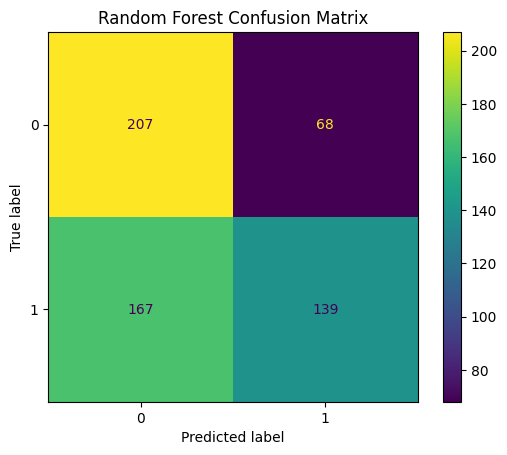

SVM Cross-Validation Accuracy: 51.66%
SVM Test Set Accuracy: 52.50%


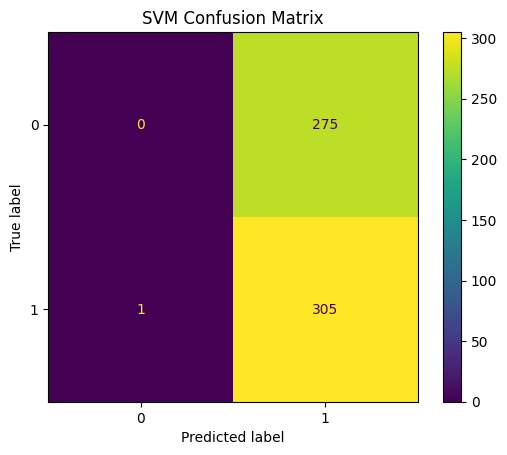

GBM Cross-Validation Accuracy: 64.99%
GBM Test Set Accuracy: 68.85%


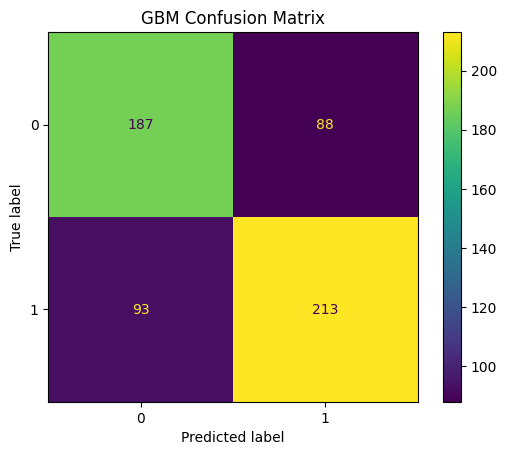

Sharpe Ratio: 0.03
Maximum Drawdown: -5.52%


In [44]:
def main():
    ticker = "AAPL"

    try:
        # Fetch and preprocess recent 7 days data
        data = fetch_recent_data(ticker, days=7)
        data = preprocess_data(data)
        data = add_technical_indicators(data)
        data = add_volatility_metrics(data)
        data = add_time_based_features(data)

        # Prepare data for modeling
        X = data.drop(['Close', 'Return'], axis=1).fillna(0).values
        y = (data['Return'] > 0).astype(int).values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

        # Train and evaluate Random Forest
        model_rf = build_random_forest_model(X_train, y_train)
        cross_validate_and_evaluate(model_rf, X, y, X_test, y_test, "Random Forest")

        # Train and evaluate SVM Model
        model_svm = build_svm_model(X_train, y_train)
        cross_validate_and_evaluate(model_svm, X, y, X_test, y_test, "SVM")

        # Train and evaluate GBM Model
        model_gbm = build_gbm_model(X_train, y_train)
        cross_validate_and_evaluate(model_gbm, X, y, X_test, y_test, "GBM")

        # Evaluate Financial Metrics
        evaluate_financial_metrics(data)

    except ValueError as e:
        print(e)

# Run the main function
if __name__ == "__main__":
    main()
